### Analysis and plotting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import datetime as dt
import xarray as xr
from scipy import stats
import re
from scipy.signal import argrelextrema, argrelmax

%matplotlib inline

In [2]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles 

---
## Open data files

---
---
#### Open our merged GOES-CUES dataset

In [3]:
cues_ds = pd.read_pickle('goes-cues_2017-2020.pkl')
cues_ds = cues_ds.to_xarray()

Load MODIS observations of the CUES site

In [4]:
#modis_1 = pd.read_pickle('./MODIS_data/cues_2017_1-59.pkl')
#modis_2 = pd.read_pickle('./MODIS_data/cues_2017_60-120.pkl')
#
## Concatenate the two MODIS time series together
#modis = pd.concat([modis_1, modis_2], ignore_index=True)

When do we have ASTER observations of this site? (convert from UTC to UTC-8)

In [6]:
# Find all our ASTER files for the CUES site
directory1 = r'//j-lundquist-3.ce.washington.edu/storage/spestana/ASTER/AST_L1T/geotiff/T/T_Tuolumne-and-CUES/T_Tuolumne_only/'
directory2 = r'//j-lundquist-3.ce.washington.edu/storage/spestana/ASTER/AST_L1T/geotiff/T/T_Tuolumne-and-CUES/T_both/'

aster_files = getListOfFiles(directory1) + getListOfFiles(directory2)

## Parse the date and time from ASTER filenames
aster_datetimes = []
for fpath in aster_files:
    #fn = re.split('\/+|\\+',fpath)[-1] # re method
    fn = fpath.split('/')[-1] # non-re method
    MM = fn.split('_')[2][3:5]
    DD = fn.split('_')[2][5:7]
    YYYY = fn.split('_')[2][7:11]
    hh = fn.split('_')[2][11:13]
    mm = fn.split('_')[2][13:15]
    ss = fn.split('_')[2][15:17]
    aster_datetimes.append(pd.Timestamp('{}-{}-{} {}:{}:{}'.format(YYYY, MM, DD, hh, mm, ss)) - pd.Timedelta(hours=8))

aster = pd.DataFrame({'datetime': aster_datetimes, 'filepath': aster_files})
aster.sort_values('datetime',inplace=True)
aster.reset_index(inplace=True, drop=True)

Set font sizes for plots

In [7]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#### Make a quick plot

Make sure we're looking at the right information

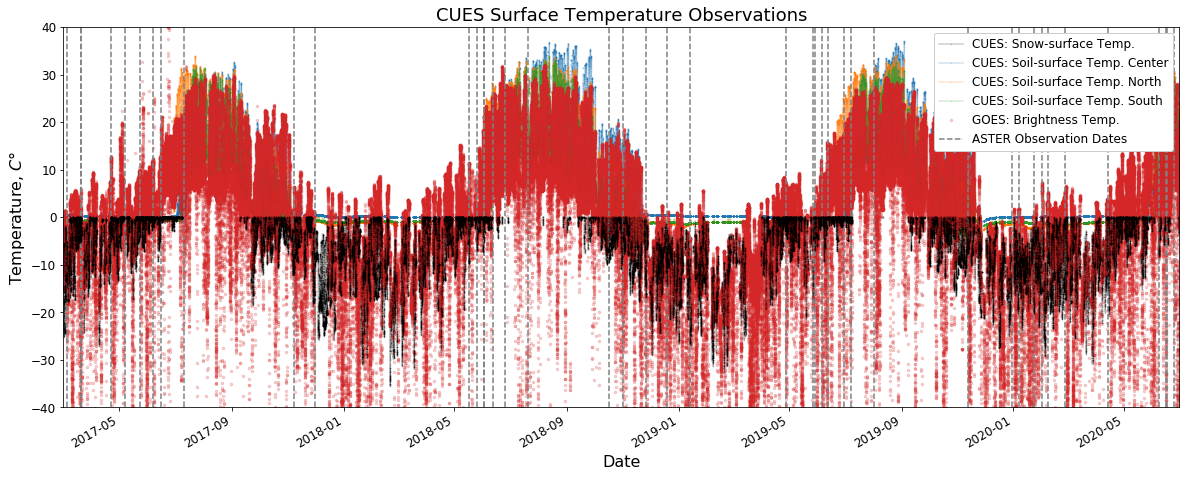

In [8]:
# Set start and end dates for time period we want to look at
startdate = cues_ds.datetime.min().values
enddate = cues_ds.datetime.max().values
#startdate = pd.Timestamp('2017-03-20')
#enddate = pd.Timestamp('2017-03-21')

alpha = 0.2
condition = cues_ds.cloud_flag==0

# Set up figure
fig, ax = plt.subplots(figsize=(20,7))

# Plot CUES snow surface temperature
cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].where(condition).plot(
    c='k', marker='.', ax=ax, markersize=1, linestyle='-', zorder=99, alpha=alpha)

# Plot CUES soil surface temperature
cues_ds['soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)'].where(condition).plot(ax=ax, linestyle='-', marker='.', markersize=1, alpha=alpha)
cues_ds['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'].where(condition).plot(ax=ax, linestyle='-', marker='.', markersize=1, alpha=alpha)
cues_ds['soil temp at 0cm  south; soil thermistor at 0cm  south; (deg C)'].where(condition).plot(ax=ax, linestyle='-', marker='.', markersize=1, alpha=alpha)

# Plot GOES brightness temperature
cues_ds.goes_tb_c.where(condition).plot(c='tab:red', linestyle='none', marker='.', markersize=5, ax=ax, alpha=alpha)

# Plot when we have ASTER observations of the CUES site
for aster_datetime in aster.datetime:
    plt.axvline(x=aster_datetime, color='grey', linestyle='--')

ax.set_xlim([startdate,enddate])
ax.set_ylim([-40,40])
ax.set_ylabel('Temperature, $C\degree$')
ax.set_xlabel('Date')

# Make legend
lines = [ax.lines[0], ax.lines[1], ax.lines[2], ax.lines[3], ax.lines[4], ax.lines[5]]
labels = ['CUES: Snow-surface Temp.', 
          'CUES: Soil-surface Temp. Center', 
          'CUES: Soil-surface Temp. North', 
          'CUES: Soil-surface Temp. South',
          'GOES: Brightness Temp.',
         'ASTER Observation Dates']
ax.legend(lines, labels, loc='upper right', facecolor='white', framealpha=1)

# Set title
plt.title('CUES Surface Temperature Observations');

# Save figure image
#plt.savefig('goes-cues-Mar2017-Dec2019.jpg',dip=300);

---

#### Plots and analysis

It looks like "no snow" is anywhere below 5 cm of snow depth.

And I think soil temperatures <= 1 C are typically burried in snow, so I will use a threshold to ignore those values for now.

In [9]:
snow_depth_treshold = 5 # cm

soil_t_threshold = 1 # deg C

Compute mean soil temps

In [10]:
soil_temps = cues_ds[['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)',
'soil temp at 0cm  south; soil thermistor at 0cm  south; (deg C)',
'soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)']]

cues_ds['mean_soil_temp'] = xr.DataArray( soil_temps.to_dataframe().mean(axis=1) )

Compute daily median snow depth

In [12]:
# resample to daily and compute median
cues_ds['daily_median_snow_depth'] = cues_ds['snow depth  remote boom;  ultrasonic depth pinger on remote boom; (cm)'].resample(datetime="1D").median()
# fill nan values by day
cues_ds['daily_median_snow_depth'] = cues_ds['daily_median_snow_depth'].to_dataframe().loc[cues_ds.to_dataframe().index].fillna(method='bfill')
# set snow depth to 0 when our soil is too warm
cues_ds['daily_median_snow_depth'][cues_ds.mean_soil_temp>soil_t_threshold] = 0
# squeeze to remove extra dim that gets created in here
cues_ds['daily_median_snow_depth'] = cues_ds.daily_median_snow_depth.squeeze()

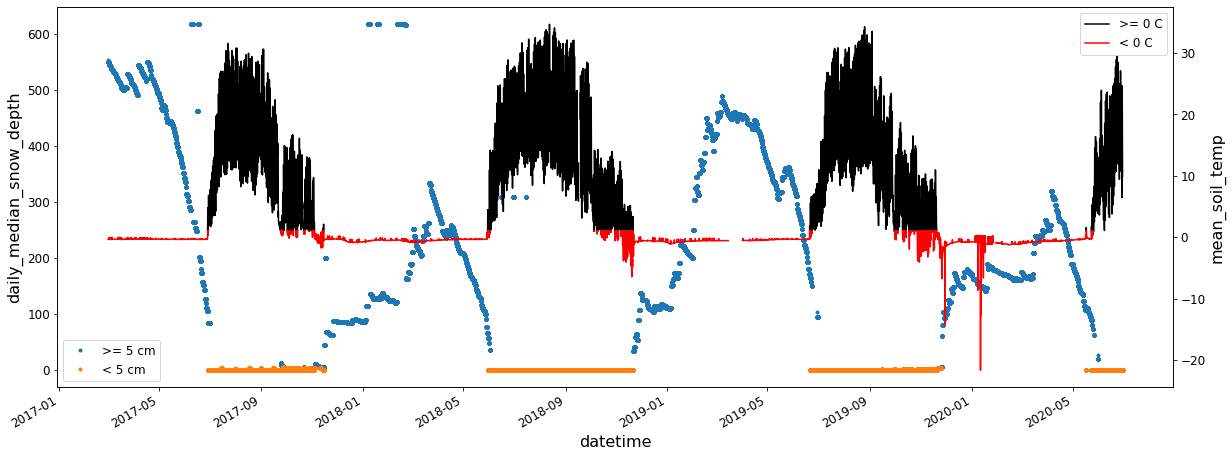

In [13]:
fig, ax = plt.subplots(figsize=(20,7))


cues_ds.daily_median_snow_depth.where(cues_ds.daily_median_snow_depth>=snow_depth_treshold).plot(linestyle='none',marker='.',ax=ax, label='>= 5 cm')
cues_ds.daily_median_snow_depth.where(cues_ds.daily_median_snow_depth<snow_depth_treshold).plot(linestyle='none',marker='.',ax=ax, label='< 5 cm')

plt.legend(loc='lower left')

ax2 = ax.twinx()

cues_ds.mean_soil_temp.where(cues_ds.mean_soil_temp>soil_t_threshold).plot(ax=ax2, color='k', label='>= 0 C')
cues_ds.mean_soil_temp.where(cues_ds.mean_soil_temp<=soil_t_threshold).plot(ax=ax2, color='r', label='< 0 C')
#.where(cues_ds['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'] > soil_t_threshold).plot(ax=ax2)



plt.legend(loc='upper right')

From the plot above it looks like using snow depth is the better way to determine if we want snow or soil temperature.

Create a new "surface temperature" that's snow OR soil:

In [14]:
snow_depth_treshold = 5 # cm

# Create the surface temperature field with the snow surface temperature value everywhere
cues_ds['surface_temperature'] = cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].copy()
# Wherever snow depth is below the threshold, set surface temperature field to mean soil temperature
cues_ds['surface_temperature'][cues_ds.daily_median_snow_depth<snow_depth_treshold] = cues_ds.mean_soil_temp[cues_ds.daily_median_snow_depth<snow_depth_treshold]

#cues['surface_temperature_source'] = [ "snow" if depth >= snow_depth_treshold else "soil" for depth in cues_ds.daily_median_snow_depth]

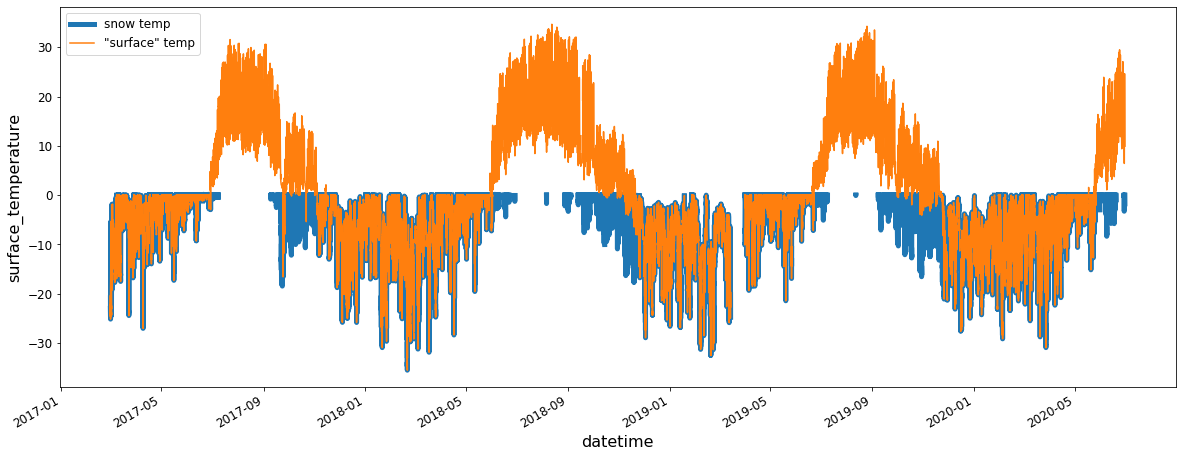

In [19]:
fig, ax = plt.subplots(figsize=(20,7))

cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].plot(ax=ax, label='snow temp', linewidth='5')
cues_ds.surface_temperature.plot(ax=ax, label='"surface" temp')

plt.legend()

I don't know if I like this "surface temperature" field too much. I'll probably want to change it.

Text(0.5, 1.0, 'GOES-16 ABI Band 14 ($11.2 \\mu m$)\nand CUES Ground-based Observations')

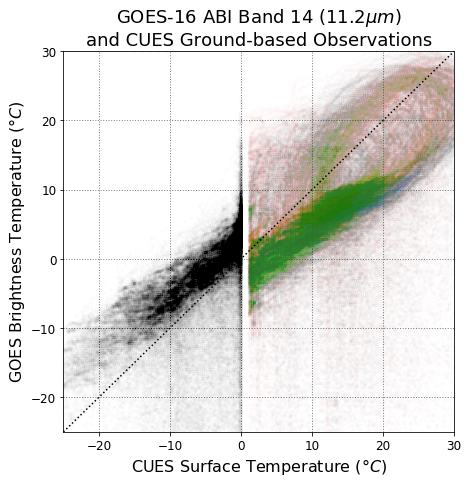

In [20]:
plt.figure(figsize=(7,7))
# gridlines
plt.grid(color='grey', linestyle=':', linewidth=1)


## GOES Tb vs Surface Temp
#plt.plot(cues_ds.surface_temperature.where(cues_ds.cloud_flag==0),
#         cues_ds.goes_tb_c.where(cues_ds.cloud_flag==0),
#         '.k',alpha=0.1)


# GOES Tb vs snow temp
plt.plot(cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].where(cues_ds.cloud_flag==0),
         cues_ds.goes_tb_c.where(cues_ds.cloud_flag==0),
         '.k',alpha=0.005)

# GOES Tb vs soil temp
plt.plot(cues_ds['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'].where(cues_ds['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'] > soil_t_threshold),
         cues_ds.goes_tb_c.where((cues_ds.cloud_flag==0) &(cues_ds['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'] > soil_t_threshold)),
         '.',alpha=0.005)
plt.plot(cues_ds['soil temp at 0cm  south; soil thermistor at 0cm  south; (deg C)'].where(cues_ds['soil temp at 0cm  south; soil thermistor at 0cm  south; (deg C)'] > soil_t_threshold),
         cues_ds.goes_tb_c.where((cues_ds.cloud_flag==0) & (cues_ds['soil temp at 0cm  south; soil thermistor at 0cm  south; (deg C)'] > soil_t_threshold)),
         '.',alpha=0.005)
plt.plot(cues_ds['soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)'].where(cues_ds['soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)'] > soil_t_threshold),
         cues_ds.goes_tb_c.where((cues_ds.cloud_flag==0) & (cues_ds['soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)'] > soil_t_threshold)),
         '.',alpha=0.005)

plt.ylabel('GOES Brightness Temperature ($\degree C$)')
plt.xlabel('CUES Surface Temperature ($\degree C$)')
plt.xlim([-25,30])
plt.ylim([-25,30])

# 1-to-1 line for reference
plt.plot([-25,30],[-25,30],'k:')

# add legend
#plt.legend()

# zero lines for reference
#plt.plot([-25,20],[0,0],':',c='lightgrey')
#plt.plot([0,0],[-25,20],':',c='lightgrey')

plt.title('GOES-16 ABI Band 14 ($11.2 \mu m$)\nand CUES Ground-based Observations')

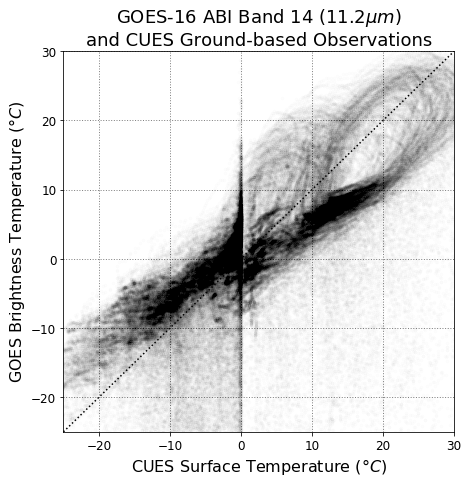

In [21]:
plt.figure(figsize=(7,7))
# gridlines
plt.grid(color='grey', linestyle=':', linewidth=1)


# GOES Tb vs Surface Temp
plt.plot(cues_ds.surface_temperature.where(cues_ds.cloud_flag==0),
         cues_ds.goes_tb_c.where(cues_ds.cloud_flag==0),
         '.k',alpha=0.007)

plt.ylabel('GOES Brightness Temperature ($\degree C$)')
plt.xlabel('CUES Surface Temperature ($\degree C$)')
plt.xlim([-25,30])
plt.ylim([-25,30])

# 1-to-1 line for reference
plt.plot([-25,30],[-25,30],'k:')

# add legend
#plt.legend()

# zero lines for reference
#plt.plot([-25,20],[0,0],':',c='lightgrey')
#plt.plot([0,0],[-25,20],':',c='lightgrey')

plt.title('GOES-16 ABI Band 14 ($11.2 \mu m$)\nand CUES Ground-based Observations');

Compute some stats

In [22]:
def plot1to1(_x, _y, x_label, y_label, startdate, enddate, point_color='k', heatmap_cmap=None):
    _x = _x.sel(datetime=slice(startdate, enddate))
    _y = _y.sel(datetime=slice(startdate, enddate))

    # Linear regression between x and y
    x, y, slope, intercept, r_value, p_value, std_err, rmse, mbe, mae, covar = quickstats(_x, _y)
    fit = slope*x + intercept
    # Compute some more stats between x and y:
    #print('r-squared = {}'.format(np.round(r_value**2,2)))

    
    plt.figure(figsize=(5.5,5.5))
    # Plot gridlines
    plt.grid(color='grey', linestyle=':', linewidth=1)
    # Plot points and best linear fit
    #plt.plot(x, fit, ':r', zorder=99)

    if heatmap_cmap == None:
        plt.plot(x,y,'.',color=point_color,markersize=5,alpha=0.5)
    else:
        # Create 2d histogram "heatmap"
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=75)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        # Plot "heatmap"
        plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=heatmap_cmap)
        plt.colorbar(label='number of records')

    # Plot 1-to-1 line
    plt.plot([-30,30],[-30,30],':k')

    # Set axes limits
    plt.xlim([-30,30])
    plt.ylim([-30,30])

    # Set axes labels, plot title
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title('{} -- {}\n$RMSE$ = {}, mean bias = {}'.format(startdate,enddate,
                                                            np.round(rmse,2),
                                                           np.round(mbe,2)))
    plt.tight_layout()
    
    return None

def quickstats(_x,_y):
    # remove nan values from input _x and _y before linear regression
    df1 = pd.DataFrame({'x': _x})
    df1['y'] = _y
    df1 = df1.dropna()
    x = df1.x
    y = df1.y

    # Linear regression between x and y
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Root Mean Squared Error
    rmse = np.sqrt(np.mean(np.square(y - x)))
    
    # Mean Bias Error
    mbe = np.mean(y - x)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(y - x))
    
    # Covariance
    X = np.stack((x, y), axis=0)
    covar = np.cov(X)
    
    return x, y, slope, intercept, r_value, p_value, std_err, rmse, mbe, mae, covar

In [23]:
from datetime import timedelta, datetime

def datetimerange(start_date, end_date, n_hours):
    # https://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python/1060330#1060330
    # for every hour in this date range
    for n in range(int ( (end_date - start_date).total_seconds() / 3600 )):
        # if we've moved n_hours
        if n % n_hours == 0:
            # return the start date + that many hours we've stepped forward
            yield start_date + timedelta(hours=n)

---

# Compute Stats:

### GOES Tb vs snow

Compute statistics over a short time window (1-hour to daily) that describe how well GOES Tb matches ground-based measurements of Tss.

Here we are filtering to only look at snow surface temperature using:
* cloud flag = 0
* daily median snow depth $\geq$ 5 cm

In [28]:
###
### FOR ENTIRE TIMESERIES
###
start_date = datetime(2017, 3, 1)
end_date = datetime(2020, 6, 30)

n_hours = 1 # take n-hour steps through the timeseries to compute statistics

df = pd.DataFrame(columns=['datetime', 'rsquared'])

# Set conditions for cloud flag and minimum snow depth
snow_depth_treshold = 5 #cm

conditions = (cues_ds.cloud_flag == 0) & (cues_ds.daily_median_snow_depth >= snow_depth_treshold)

for single_datetime in datetimerange(start_date, end_date, n_hours=n_hours):
    #print(single_datetime.strftime("%Y-%m-%d %H:%M:%S"))

    startdate = single_datetime
    enddate = single_datetime + timedelta(hours=n_hours)

    _x = cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].where(conditions)
    x_label = 'CUES Snow-Surface Temp. [$\degree C$]'

    _y = cues_ds.goes_tb_c.where(conditions)
    y_label = 'GOES Brightness Temp. [$\degree C$]'

    point_color = 'k'
    heatmap_cmap = 'Greys'
    try:
        #plot1to1(_x, _y, x_label, y_label, startdate, enddate, point_color, heatmap_cmap)
        #plt.savefig('figures/{}.jpg'.format(single_date))
        _, _, slope, intercept, r_value, p_value, std_err, rmse, mbe, mae, covar = quickstats(_x.sel(datetime=slice(startdate, enddate)),
                                                                 _y.sel(datetime=slice(startdate, enddate)))
        df = df.append({'datetime' : single_datetime,
                        'slope' : slope,
                        'rsquared' : r_value**2,
                       'rmse' : rmse,
                       'mbe' : mbe,
                       'mae' : mae,
                       'covar' : covar[0,1]}, ignore_index=True)
    except ValueError:
        #print('nodata: skipping {}'.format(single_date))
        pass

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\scipy\stats\_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\scipy\sta

In [29]:
df = df.set_index('datetime')
df['year_month'] = df.index.to_period('M')

In [30]:
df

,rsquared,covar,mae,mbe,rmse,slope,year_month
datetime,,,,,,,
2017-03-01 00:00:00,0.269137,0.049384,7.545328,7.545328,7.579756,0.076102,2017-03
2017-03-01 01:00:00,0.002410,-0.004425,7.301173,7.301173,7.332208,-0.009502,2017-03
2017-03-01 02:00:00,0.131282,0.046228,7.288955,7.288955,7.366979,0.035050,2017-03
2017-03-01 03:00:00,0.047808,-0.016753,8.645459,8.645459,8.666116,-0.049793,2017-03
2017-03-01 04:00:00,0.460258,0.150575,8.672634,8.672634,8.711999,0.150822,2017-03
...,...,...,...,...,...,...,...
2020-05-25 04:00:00,0.356187,0.022579,6.250312,6.250312,6.252640,0.702900,2020-05
2020-05-25 05:00:00,0.978629,1.162595,6.564750,6.564750,6.568759,0.839403,2020-05
2020-05-25 06:00:00,0.912810,0.598859,6.684228,6.684228,6.702329,1.698620,2020-05


In [32]:
df.to_csv('goes-cues-2017-2020-1hr_snow.csv')
df.to_pickle('goes-cues-2017-2020-1hr_snow.pkl')